
Training variant: basic-bernoulli


100%|██████████| 9.91M/9.91M [00:00<00:00, 120MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 17.5MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 56.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.71MB/s]


[basic-bernoulli] Episode 100, Avg Reward: 0.870
[basic-bernoulli] Episode 200, Avg Reward: 0.890
[basic-bernoulli] Episode 300, Avg Reward: 0.900
[basic-bernoulli] Episode 400, Avg Reward: 0.880
[basic-bernoulli] Episode 500, Avg Reward: 0.860
[basic-bernoulli] Episode 600, Avg Reward: 0.870
[basic-bernoulli] Episode 700, Avg Reward: 0.920
[basic-bernoulli] Episode 800, Avg Reward: 0.900
[basic-bernoulli] Episode 900, Avg Reward: 0.910
[basic-bernoulli] Episode 1000, Avg Reward: 0.860

Training variant: baseline-bernoulli
[baseline-bernoulli] Episode 100, Avg Reward: 0.890
[baseline-bernoulli] Episode 200, Avg Reward: 0.970
[baseline-bernoulli] Episode 300, Avg Reward: 0.920
[baseline-bernoulli] Episode 400, Avg Reward: 0.950
[baseline-bernoulli] Episode 500, Avg Reward: 0.960
[baseline-bernoulli] Episode 600, Avg Reward: 0.900
[baseline-bernoulli] Episode 700, Avg Reward: 0.940
[baseline-bernoulli] Episode 800, Avg Reward: 0.930
[baseline-bernoulli] Episode 900, Avg Reward: 0.920
[ba

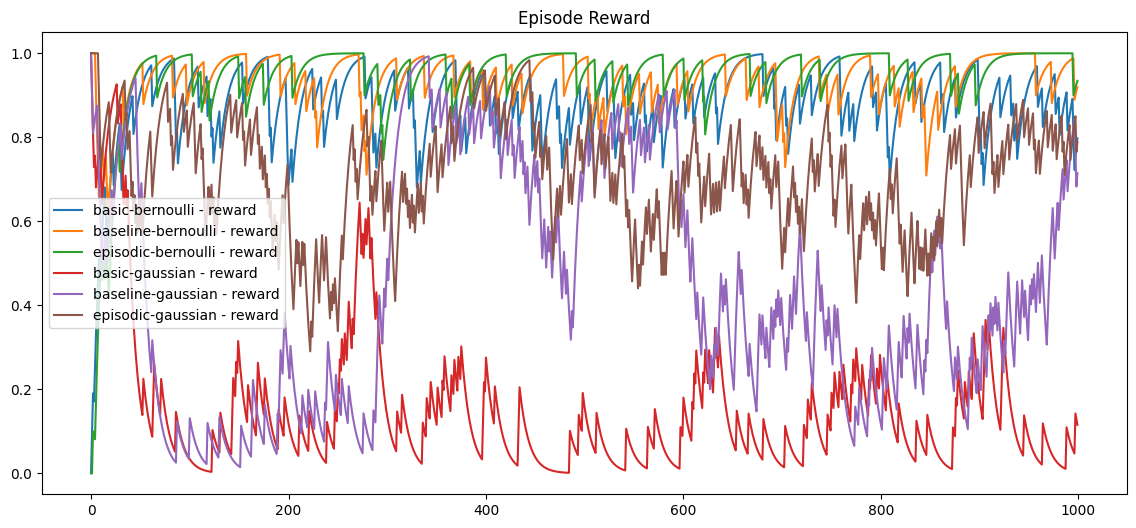

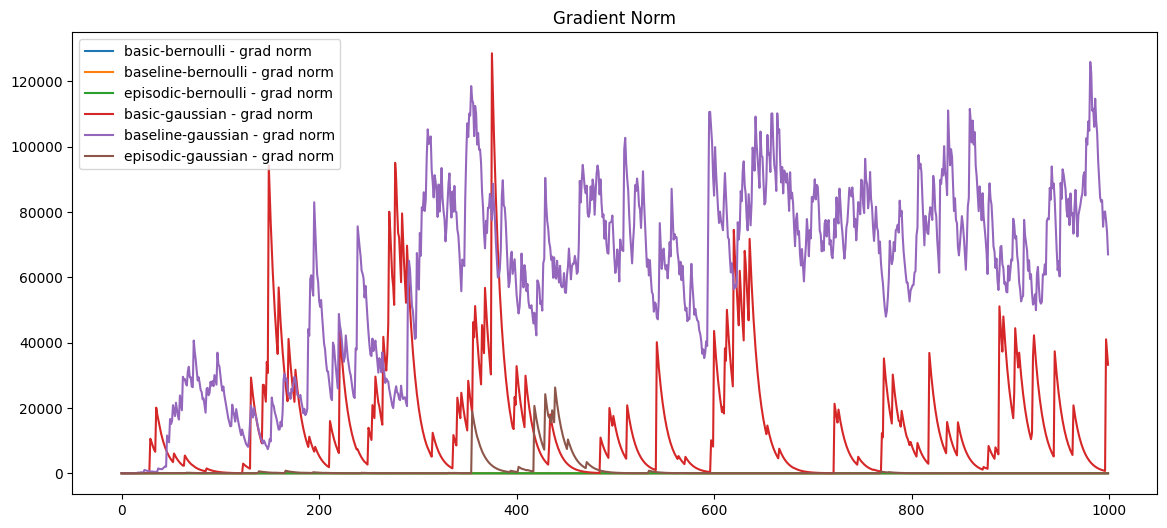

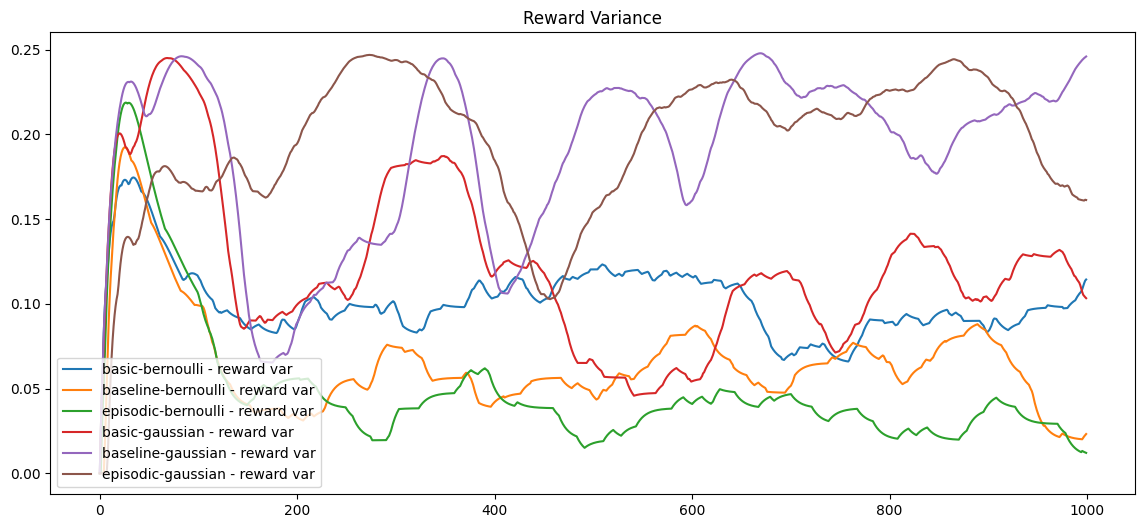

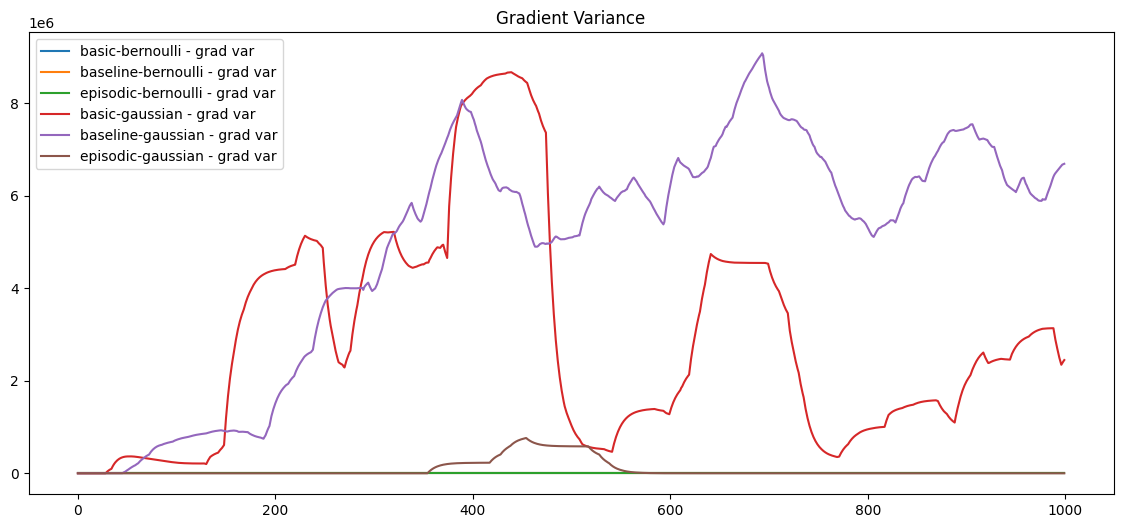

In [1]:
# REINFORCE Variants in a Classification Gym Environment
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from collections import deque
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# ---- Set random seeds for reproducibility ----
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ---- Environment (MNIST binary classification) ----
class ClassificationEnv(gym.Env):
    def __init__(self):
        super().__init__()
        transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
        data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        X = data.data.numpy().reshape(-1, 28*28) / 255.0
        y = data.targets.numpy()

        y = (y == 0).astype(np.int64)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(784,), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(2)

        self.max_steps = len(self.X_train)
        self.index = 0

    def reset(self):
        self.index = np.random.randint(0, len(self.X_train))
        self.current_obs = self.X_train[self.index]
        self.current_label = self.y_train[self.index]
        return self.current_obs.astype(np.float32)

    def step(self, action):
        reward = 1.0 if action == self.current_label else 0.0
        done = True
        return self.current_obs.astype(np.float32), reward, done, {"label": self.current_label}

# ---- Policy Networks ----
class BernoulliPolicyNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        logits = self.fc(x)
        probs = torch.sigmoid(logits)
        return probs

class GaussianPolicyNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc_mu = nn.Linear(input_dim, 1)
        self.fc_logstd = nn.Linear(input_dim, 1)

    def forward(self, x):
        mu = self.fc_mu(x)
        log_std = self.fc_logstd(x)
        std = torch.exp(torch.clamp(log_std, min=-10, max=2))
        return mu, std

# ---- REINFORCE Agent ----
class REINFORCEAgent:
    def __init__(self, input_dim, variant="basic", distribution="bernoulli", gamma=0.99):
        self.variant = variant
        self.gamma = gamma
        self.baseline = 0
        self.baseline_decay = 0.99
        self.distribution = distribution

        if distribution == "bernoulli":
            self.policy = BernoulliPolicyNetwork(input_dim)
        elif distribution == "gaussian":
            self.policy = GaussianPolicyNetwork(input_dim)

        self.optimizer = optim.Adam(self.policy.parameters(), lr=0.01)

        self.gradient_norms = []
        self.gradient_variance = []
        self.reward_variance = []
        self.recent_returns = []
        self.recent_grads = []

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        if self.distribution == "bernoulli":
            prob = self.policy(state)
            dist = torch.distributions.Bernoulli(prob)
        elif self.distribution == "gaussian":
            mu, std = self.policy(state)
            if torch.any(torch.isnan(mu)) or torch.any(torch.isnan(std)) or torch.any(std <= 0):
                mu = torch.zeros_like(mu)
                std = torch.ones_like(std)
            dist = torch.distributions.Normal(mu, std)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return int(action.item() > 0.5 if self.distribution == "bernoulli" else action.item() > 0), log_prob

    def update(self, log_probs, rewards):
        returns = sum(rewards)

        if self.variant == "basic":
            loss = -log_probs[0] * returns
        elif self.variant == "baseline":
            advantage = returns - self.baseline
            loss = -log_probs[0] * advantage
            self.baseline = self.baseline_decay * self.baseline + (1 - self.baseline_decay) * returns
        elif self.variant == "episodic":
            loss = -sum([(self.gamma ** t) * log_probs[t] * rewards[t] for t in range(len(rewards))])

        self.optimizer.zero_grad()
        loss.backward()

        grad_vector = []
        total_norm = 0
        for p in self.policy.parameters():
            if p.grad is not None:
                total_norm += p.grad.norm().item() ** 2
                grad_vector.append(p.grad.view(-1))

        grad_vector = torch.cat(grad_vector).detach().cpu().numpy()
        self.gradient_norms.append(np.sqrt(total_norm))
        self.recent_grads.append(grad_vector)

        if len(self.recent_grads) > 100:
            self.recent_grads.pop(0)
        if len(self.recent_grads) > 1:
            stacked = np.stack(self.recent_grads)
            self.gradient_variance.append(np.mean(np.var(stacked, axis=0)))
        else:
            self.gradient_variance.append(0.0)

        self.recent_returns.append(returns)
        if len(self.recent_returns) > 100:
            self.recent_returns.pop(0)
        self.reward_variance.append(np.var(self.recent_returns))

        self.optimizer.step()

# ---- Smoothing helper ----
def smooth_curve(data, weight=0.9):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

# ---- Training ----
def train_agent(variant="basic", distribution="bernoulli", episodes=1000):
    env = ClassificationEnv()
    agent = REINFORCEAgent(env.observation_space.shape[0], variant, distribution)
    reward_history = []

    for ep in range(episodes):
        state = env.reset()
        done = False
        log_probs = []
        rewards = []

        while not done:
            action, log_prob = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state

        agent.update(log_probs, rewards)
        reward_history.append(sum(rewards))

        if (ep + 1) % 100 == 0:
            avg = np.mean(reward_history[-100:])
            print(f"[{variant}-{distribution}] Episode {ep+1}, Avg Reward: {avg:.3f}")

    return reward_history, agent.gradient_norms, agent.reward_variance, agent.gradient_variance

# ---- Plotting ----
def plot_metrics(histories):
    plt.figure(figsize=(14, 6))
    for key, metrics in histories.items():
        plt.plot(smooth_curve(metrics[0]), label=f"{key} - reward")
    plt.title("Episode Reward")
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 6))
    for key, metrics in histories.items():
        plt.plot(smooth_curve(metrics[1]), label=f"{key} - grad norm")
    plt.title("Gradient Norm")
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 6))
    for key, metrics in histories.items():
        plt.plot(smooth_curve(metrics[2]), label=f"{key} - reward var")
    plt.title("Reward Variance")
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 6))
    for key, metrics in histories.items():
        plt.plot(smooth_curve(metrics[3]), label=f"{key} - grad var")
    plt.title("Gradient Variance")
    plt.legend()
    plt.show()

# ---- Run All Variants ----
if __name__ == "__main__":
    variants = ["basic", "baseline", "episodic"]
    distributions = ["bernoulli", "gaussian"]
    histories = {}

    for dist in distributions:
        for var in variants:
            label = f"{var}-{dist}"
            print(f"\nTraining variant: {label}")
            histories[label] = train_agent(variant=var, distribution=dist, episodes=1000)

    plot_metrics(histories)

In [2]:
def plot_metrics(histories):
    # Smoothed reward plot
    plt.figure(figsize=(14, 5))
    for key, metrics in histories.items():
        plt.plot(smooth_curve(metrics[0]), label=f"{key}")
    plt.title("Smoothed Reward per Episode\n(Reinforces learning from global reward signal)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gradient norm plot
    plt.figure(figsize=(14, 5))
    for key, metrics in histories.items():
        plt.plot(smooth_curve(metrics[1]), label=f"{key}")
    plt.title("Smoothed Gradient Norm\n(Tracks magnitude of updates through deterministic layers)")
    plt.xlabel("Episode")
    plt.ylabel("Gradient Norm")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Reward variance plot
    plt.figure(figsize=(14, 5))
    for key, metrics in histories.items():
        plt.plot(smooth_curve(metrics[2]), label=f"{key}")
    plt.title("Reward Variance\n(Variance from scalar feedback; baseline reduces this)")
    plt.xlabel("Episode")
    plt.ylabel("Reward Variance")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gradient variance plot
    plt.figure(figsize=(14, 5))
    for key, metrics in histories.items():
        plt.plot(smooth_curve(metrics[3]), label=f"{key}")
    plt.title("Gradient Variance\n(Reflects stability of REINFORCE updates)")
    plt.xlabel("Episode")
    plt.ylabel("Gradient Variance")
    plt.legend()
    plt.grid(True)
    plt.show()
